<a href="https://colab.research.google.com/github/Intertangler/bioinformatics_stockholm/blob/master/7_scRNAseq_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing single-cell RNA-seq

single-cell RNA-seq (scRNA-seq) is a technique where individual cells from a sample are separated and unique barcodes are  
introduced to label transcripts from different cellular origins. In combination with Next-Generation Sequencing, this allows  
the reconstruction of gene expression in complex heterogeneous tissues on the single cell level.  

In this computer exercise you will work with an example dataset of scRNA-seq data derived from the developing mouse cortex,  
hippocampus and ventricular zone (embryonal day E18.5). Cells were separated and barcoded using the [10X Chromium Controller](https://www.10xgenomics.com/solutions/single-cell/).  
In short, individual cells are run through a microfluidic device that deposits individual cells in small oil droplets containing a  
bead covered in barcoded cDNA probes. The cells are then lysed and the mRNA they contain hybridizes with the probes, allowing  
amplification and the incorporation of the barcodes. Next, the resulting cDNA pool is sequenced and the resulting reads are  
separated based on the barcodes they contain.  

The primary data processing of the data has already been done and we will do some basic analysis using numpy, scipy and scikitlearn,  
very useful packages for any python programmer. There are also many packages to process single-cell data involving complex  
mathematics and different layers of data as well as custom file-formats to keep track of it all.

In [1]:
## Load packages

import os
import sys
import csv
import gzip
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import scipy.io

We have saved the data that we will use in the github repository, so we will have to connect that to the collab session with the functions below

In [2]:
!git clone https://github.com/Intertangler/bioinformatics_stockholm.git
sys.path.insert(0,'/Intertangler/bioinformatics_stockholm.git')

Cloning into 'bioinformatics_stockholm'...
remote: Enumerating objects: 187, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (161/161), done.
remote: Total 266 (delta 84), reused 84 (delta 23), pack-reused 79
Receiving objects: 100% (266/266), 41.30 MiB | 25.28 MiB/s, done.
Resolving deltas: 100% (105/105), done.


We first need to open the data. Currently the data is saved in a folder called 'filtered_feature_bc_matrix'. The folder contains three files:
* barcodes.tsv.gz: contains a list of the barcodes that were identified.
* features.tsv.gz: contains the gene names and ensemble IDs of the features that were used for alignment.
* matrix.mtx.gz: a matrix that contains the count numbers of each feature per barcode. It does not contain any data on the reads or alignments.

The data is still compressed in .gz format, but we can decompress it using gzip.

## Loading the data

We will first need to upload the data to google colab. Run the cell below and upload the 3 files discussed above.  
Uploading the matrix can take a while, about a minute or two.
After that you can run the cell below it to load it into pyton.

In [3]:
## Load the data matrix
matrix_dir = "bioinformatics_stockholm/filtered_feature_bc_matrix"
mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx.gz"))

## Load the gene IDs and gene names from the same file
features_path = os.path.join(matrix_dir, "features.tsv.gz")
feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, mode='rt'), delimiter="\t")] ## We take the first item of every row
gene_names = [row[1] for row in csv.reader(gzip.open(features_path, mode='rt'), delimiter="\t")] ## We take the second item of every row

## Load the barcodes
barcodes_path = os.path.join(matrix_dir, "barcodes.tsv.gz")
barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, mode='rt'), delimiter="\t")]

## It's usually a good idea to check that our data structures have the shapes that we expect.
## You can use an f-string to print variable inside of string by using curly brackets.
print(f'Shape of the dataframe {mat.shape}, there are {len(gene_names)} features and {len(barcodes)} cells')

Shape of the dataframe (31053, 1301), there are 31053 features and 1301 cells


## Numpy and scipy

In this tutorial we are using two python packages that you might not have encountered yet, but that you will probably be using quite a lot if you continue doing bioinformatics.

Ther first is **Numpy** (Numerical python), a package that makes it very easy to work with *n-dimensional arrays*. an array is a data structure that stores data of the same type, as opposed to a list that can contain anything. An **n-dimensional** array is an array with **n** dimensions that contains the same number of values in any direction i.e. a 1-dimensional array is just a list of items of the same data type, a 2-dimensional array is like a table and a 3-dimensional array is like a cube. Numpy allows you to easily manipulate them and do simple computations on them like taking the mean per row, column or whole structure.

**Scipy** (Scientific python) is a package that contains all sort of more complicated computations and algorithms for use in scientific or engineering applications. Scipy often uses numpy under the hood and is very well documented and maintained. This package allows you to do very complicated computations without having a lot of experience writing scripts. For instance if you want to do some statistics or linear algebra you can use this package.

## Matrices

You can create a numpy array with the following function:  
  
**np.array()**  
  
We imported numpy as np, so np.array tells the interpreter to look for function array in numpy.  
This is what a regular (dense) numpy array looks like:  

In [4]:
np.array([[1, 0, 0, 0],  
          [0, 0, 0, 0],  
          [1, 0, 0, 0],  
          [0, 0, 0, 0]])

array([[1, 0, 0, 0],
       [0, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 0]])

The matrix we loaded in the previous section is in the form of a "sparse" matrix. It is essentially a 2-dimensional array, but stored as a list of non-zero values with the corresponding indices (similar to coordinates). So if you have a lot of zeros in your data (like in scRNA-seq) it is a lot more efficient to store your data like that.

The same array we created above would in that case be internally saved like this, where we only remember in what column and row a nonzero value appeared:  
(0, 0) 1  
(0, 2) 1

In [5]:
## Does it make sense to save out data as a sparse matrix?
## Let's print some information about our matrix
print(f'Total number of positions in the data matrix: {mat.shape[0]*mat.shape[1]}')
print(f'Total number of stored positions: {mat.nnz}')
print(f'Percentage of elements in the array that is not zero: {(100*mat.nnz)/(mat.shape[0]*mat.shape[1])}')

Total number of positions in the data matrix: 40399953
Total number of stored positions: 4220492
Percentage of elements in the array that is not zero: 10.446774529663438


The gene names and cell barcodes are saved as lists, which you have encountered before.  
Now that we know how our data is stored we can have a look at how it is distributed.

## Quality control

First we will look at the total number of transcript identified in each cell. In this case those are UMIs (Unique Molecular Identifiers).  
We also need to filter out genes that are non-informative. That means genes that are not expressed in enough cells to be reliable for later analysis

In [6]:
## Total UMIs per cell
Total_UMIs = np.array(np.sum(mat, axis=0))[0]

## Number of cells expressing feature
NCells = np.array(np.sum(mat>0, axis=1))[:,0]

We can use matplotlib to plot these Quality control measures. If you were to have multiple samples it would be good to plot them separately to check that the data is comparable.

Text(0.5, 1.0, 'Total number of cells expressing gene')

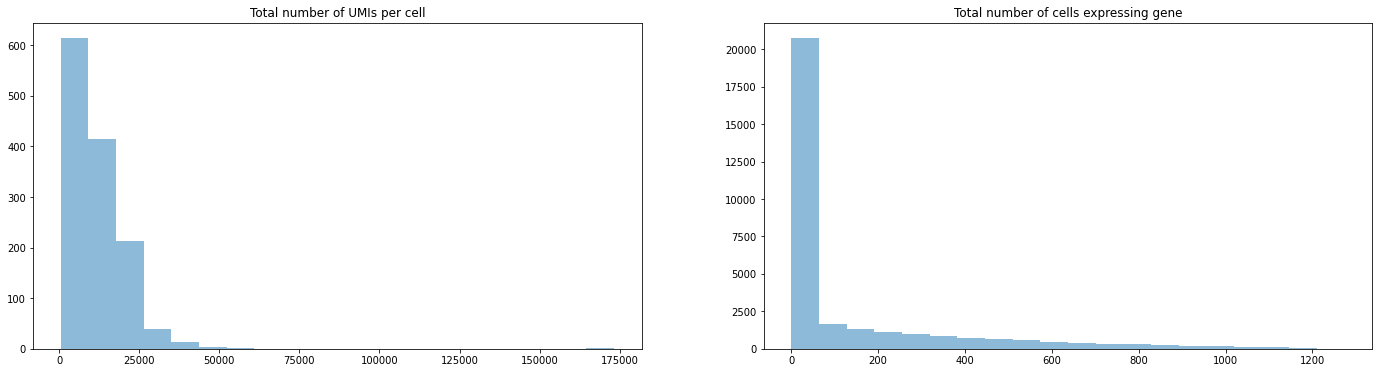

In [7]:
## First we make a figure object, this is basically the canvas we will paint our figures on
## We'll make it pretty wide because we want to fit two plots next to each other.
fig = plt.figure(figsize=(24,6))

## Next we add an axis to the figure and plot a histogram in it. We'll add a title as well
ax1 = fig.add_subplot(121) ## We have 1 row and 2 columns, this is plot #1
ax1.hist(Total_UMIs, alpha=.5, bins=20)
ax1.set_title('Total number of UMIs per cell')

## We make another axis for the number of cells expressing a gene, but this time we change the last digit in add_subplot to indicate it's a new axis
ax2 = fig.add_subplot(122) ## We have 1 row and 2 columns, this is plot #2
ax2.hist(NCells, alpha=.5, bins=20)  ## You can change the color, opacity (alpha) and many other things inside this call
ax2.set_title('Total number of cells expressing gene')

Not the kind of distribution you expected to see right? That's because single-cell data is very sparse remember! Basically it consists mostly of zeros. This makes single-cell analysis a bit tricky, since many analysis methods for bulk RNA-seq assume the data has some kind of continuous distribution (e.g. normally distributed). Luckily we can transform our data to make it fit such expectations and to identify trends. In addition we need to think about how to perform statistics on this kind of data.

For now we will perform a logarithmic transformation on our quality control measures.

In [8]:
## Total UMIs. We add 1 to every value because we can't divide by zero
Total_UMIs_log = np.log10(Total_UMIs + 1)

## Number of cells
NCells_log = np.log10(NCells + 1)

We can now plot the transformed distributions, as an example I changed the colors, opacity and number of bins used to plot the data.

Text(0.5, 1.0, 'Log10 cells expressing gene')

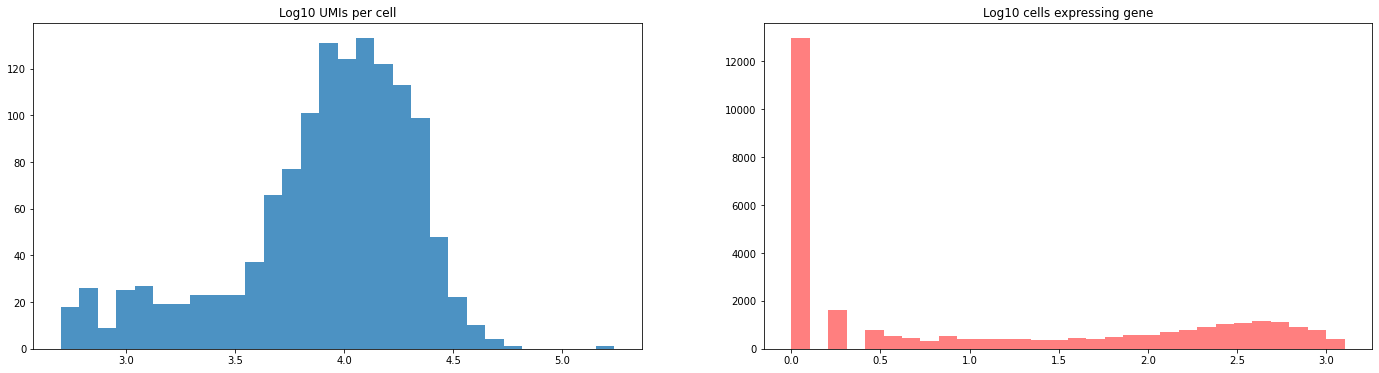

In [9]:
## Create a figure with 2 axes showing the log-transformed values

## Create a figure
fig = plt.figure(figsize=(24,6))

## Plot the total UMIs
ax1 = fig.add_subplot(121)
ax1.hist(Total_UMIs_log, alpha=.8, bins=30) ## Opacity .8 makes it less see-through than .5
ax1.set_title('Log10 UMIs per cell')

## Plot the number of cells expressing gene
ax2 = fig.add_subplot(122)
ax2.hist(NCells_log, alpha=.5, bins=30, color='#FF0000') ## You can set the color by name or with a hex-code
ax2.set_title('Log10 cells expressing gene')

Looks like we do actually have a reasonable distribution! Now we can define some thresholds to filter the data. We should remove cells that have too few or too many UMIs as well as genes that are expressed in very few cells.

Text(0.5, 1.0, 'Total number of cells expressing gene')

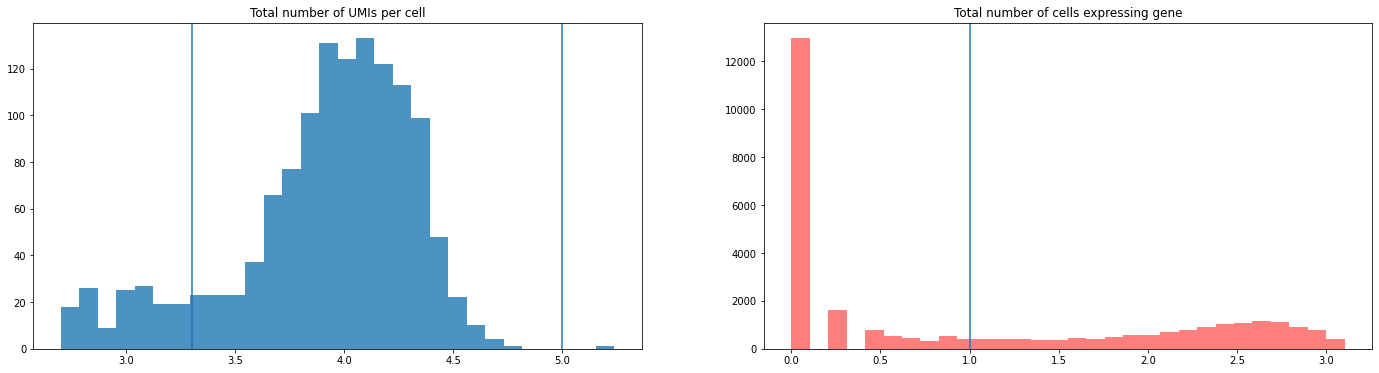

In [10]:
min_UMI = 2000
max_UMI = 1e5 ## This is the same as 100,000
min_cell = 10

## Create a figure
fig = plt.figure(figsize=(24,6))

## Plot the total UMIs
ax1 = fig.add_subplot(121)
ax1.hist(Total_UMIs_log, alpha=.8, bins=30)
ax1.axvline(np.log10(min_UMI))
ax1.axvline(np.log10(max_UMI))
ax1.set_title('Total number of UMIs per cell')

## Plot the number of cells expressing gene
ax2 = fig.add_subplot(122)
ax2.hist(NCells_log, alpha=.5, bins=30, color='#FF0000')
ax2.axvline(np.log10(min_cell))
ax2.set_title('Total number of cells expressing gene')

Next we can use these thresholds to create a boolean vector (basically the same as binary) to index our data structures. You can use the & operator or np.logical_and() to set a conditional AND for the two values.

In [11]:
## Select cells
k_x = (Total_UMIs > min_UMI) & (Total_UMIs < max_UMI)

## Select features
k_y = NCells > min_cell

## Filter barcodes and gene names
bars = np.array(barcodes)[k_x] ## only retain barcodes that are '1' in k_x
genes = np.array(gene_names)[k_y]

## Fiter the data
data = mat.toarray()[:,k_x] ## Filters cells
data = data[k_y,:] ## Filters genes

print(f'Cells after filtering: {sum(k_x)}    Genes after filtering: {sum(k_y)}')

Cells after filtering: 1154    Genes after filtering: 13241


Another useful measure is the number of genes expressed in a cell. This of course differs between cell types, but in many cases you can  
recognize debris or dead cells by the very low number of genes that are detected for a single barcode. Let's compute this measure next.

Text(0.5, 1.0, 'Number of genes vs Total UMI')

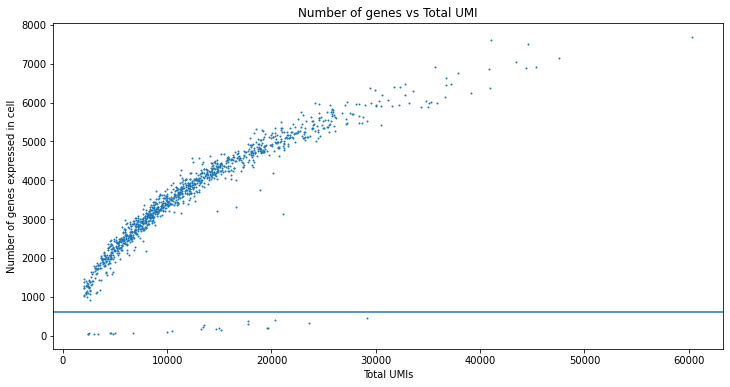

In [12]:
## First we calculate the number of genes that are expressed per cell i.e. number of non-zero values
NGenes = np.array(np.sum(mat>0, axis=0))[0]
NGenes_threshold = 600

## Plot the figure
plt.figure(figsize=(12,6))
plt.scatter(Total_UMIs[k_x], NGenes[k_x],  s=1) ## We only plot the cells we didn't already filter out
plt.xlabel('Total UMIs')
plt.ylabel('Number of genes expressed in cell')
plt.axhline(NGenes_threshold)
plt.title('Number of genes vs Total UMI')

Seems like we detected some more outliers here. Let's filter them out as well by thresholding on NGenes

In [13]:
## Select cells
k_x = (Total_UMIs > min_UMI) & (Total_UMIs < max_UMI) & (NGenes > NGenes_threshold)

## Filter the barcodes and cells
bars = np.array(barcodes)[k_x]
data = mat.toarray()[:,k_x] ## Filters cells

## Select features. First recompute NCells without the removed cells
NCells = np.array(np.sum(data>0, axis=1))
k_y = NCells > min_cell

## Filter gene names and genes
genes = np.array(gene_names)[k_y]
data = data[k_y,:] ## Filters genes

print(f'Cells after filtering: {sum(k_x)}    Genes after filtering: {sum(k_y)}')

Cells after filtering: 1129    Genes after filtering: 13163


## Normalization

Next we need to normalize the data. That means we need to account for variance that derives from the capture effiency not being stable across samples. Some cells in our dataset have more transcripts while others have less, but that might not mean this was also the case before we measured them. For now we will assume that all cells had the same number of transcripts before we took our measurements. We will thus compare the ratios of present genes. 

In [14]:
## First, we will determine the library size per cell. This is the same as total UMIs, so we can just filter the 
## Total_UMIs array we generated before so we only have the cells.
lib_size = Total_UMIs[k_x]

## Next we calculate the median library size since we'll normalize our data to that level
med_lib = np.median(lib_size)

print(f'Median library size {med_lib}')

Median library size 10993.0


Next we can divide each column by the appropriate library size and multiply every value by the median library size. The result is that each column sums to the same value.

In [15]:
data = (data / lib_size) * med_lib

We don`t want downstream analysis to be biased towards highly expressed genes, so we are going to down weigh them. You can do this by for instance taking the square-root or log transforming them like we showed earlier. Log-transforming is the most common method.

In [16]:
norm = np.log(data+1)

## Dimensional Reduction

Next we're going to try and visualize the differences between cells by plotting them in low dimensional space. Unfortunately, the cells exist in high-dimensional space *i.e.* they have many different features (genes) and we can't exactly look at all of them at the same time. We thus need to 'simplify' the data and embed the cells in low-dimensional space. This can be done using methods like Principal Component Analysis (PCA) and t-Stochastic Neighbour Embedding (tSNE). These methods try to explain as much variance as possible across features, summarizing many features into a limited number of components and then ordering cells along them.

Before we can do the PCA we need to select which features we will use. A lot of genes don't really change their expression between cell types, these are so called 'house keeper' genes. They are often involved in processes that all cells require like maintaining the Actin skeleton. We will thus look for genes that have **high variance**. To do this we will however need to control for **mean expression** since highly expressed genes tend to have higher variance.

In the code block below we train a simple machine learning model, the Support Vector Machine. You don't need to know the details about how that works, the important thing is that we model the relationship between variance and mean and we eventually select the 2,000 genes that have the strongest divergence of their variance from their mean.

In [17]:
from sklearn.svm import LinearSVR

N_features = 2000

mu = np.mean(data, axis=1)
s = np.std(data, axis=1)
cv = s/mu

log2_m = np.log2(mu)
log2_cv = np.log2(cv)

clf = LinearSVR(tol=1e-5, max_iter=20000)
clf.fit(log2_m[:, np.newaxis], log2_cv)
fitted_fun = clf.predict

# Score is the relative position with respect of the fitted curve
score = log2_cv - fitted_fun(log2_m[:, np.newaxis])
idx = np.fromiter(range(data.shape[0]), int)[np.argsort(score)][-2000:]
selected = np.zeros(data.shape[0], dtype=bool)
selected[np.sort(idx)] = True

Text(0.5, 1.0, 'Variance and mean expression of features')

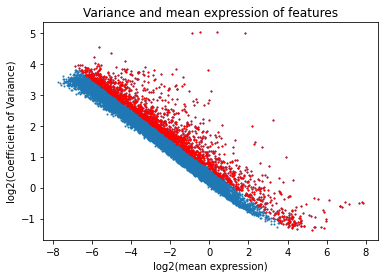

In [18]:
## Let's plot the results
plt.scatter(np.log2(mu), np.log2(cv), s=1)
plt.scatter(np.log2(mu[selected]), np.log2(cv[selected]), s=1, c='red')
plt.xlabel('log2(mean expression)')
plt.ylabel('log2(Coefficient of Variance)')
# plt.axhline(q)
plt.title('Variance and mean expression of features')

Now we simplify the data using PCA. We will generate 20 components, which will simplify downstream analysis. The function to calculate PCs can be imported from [Scikit-learn](https://scikit-learn.org/stable/), a very powerful, free to use machine-learning library that is included in every anaconda installation.

For the PCA we will use the log-scaled data, since we don't want highly expressed genes to dominate our PCA.

In [19]:
## First we setup the PCA object and we fit our normalized data to it.
from sklearn.decomposition import PCA

PCs = PCA(n_components=20)
PCs.fit(norm[selected,:])
print(f'Shape of the reduced dataframe {PCs.components_.shape}')

Shape of the reduced dataframe (20, 1129)


You should always try to have a look at the resulting components to see if they are informative.

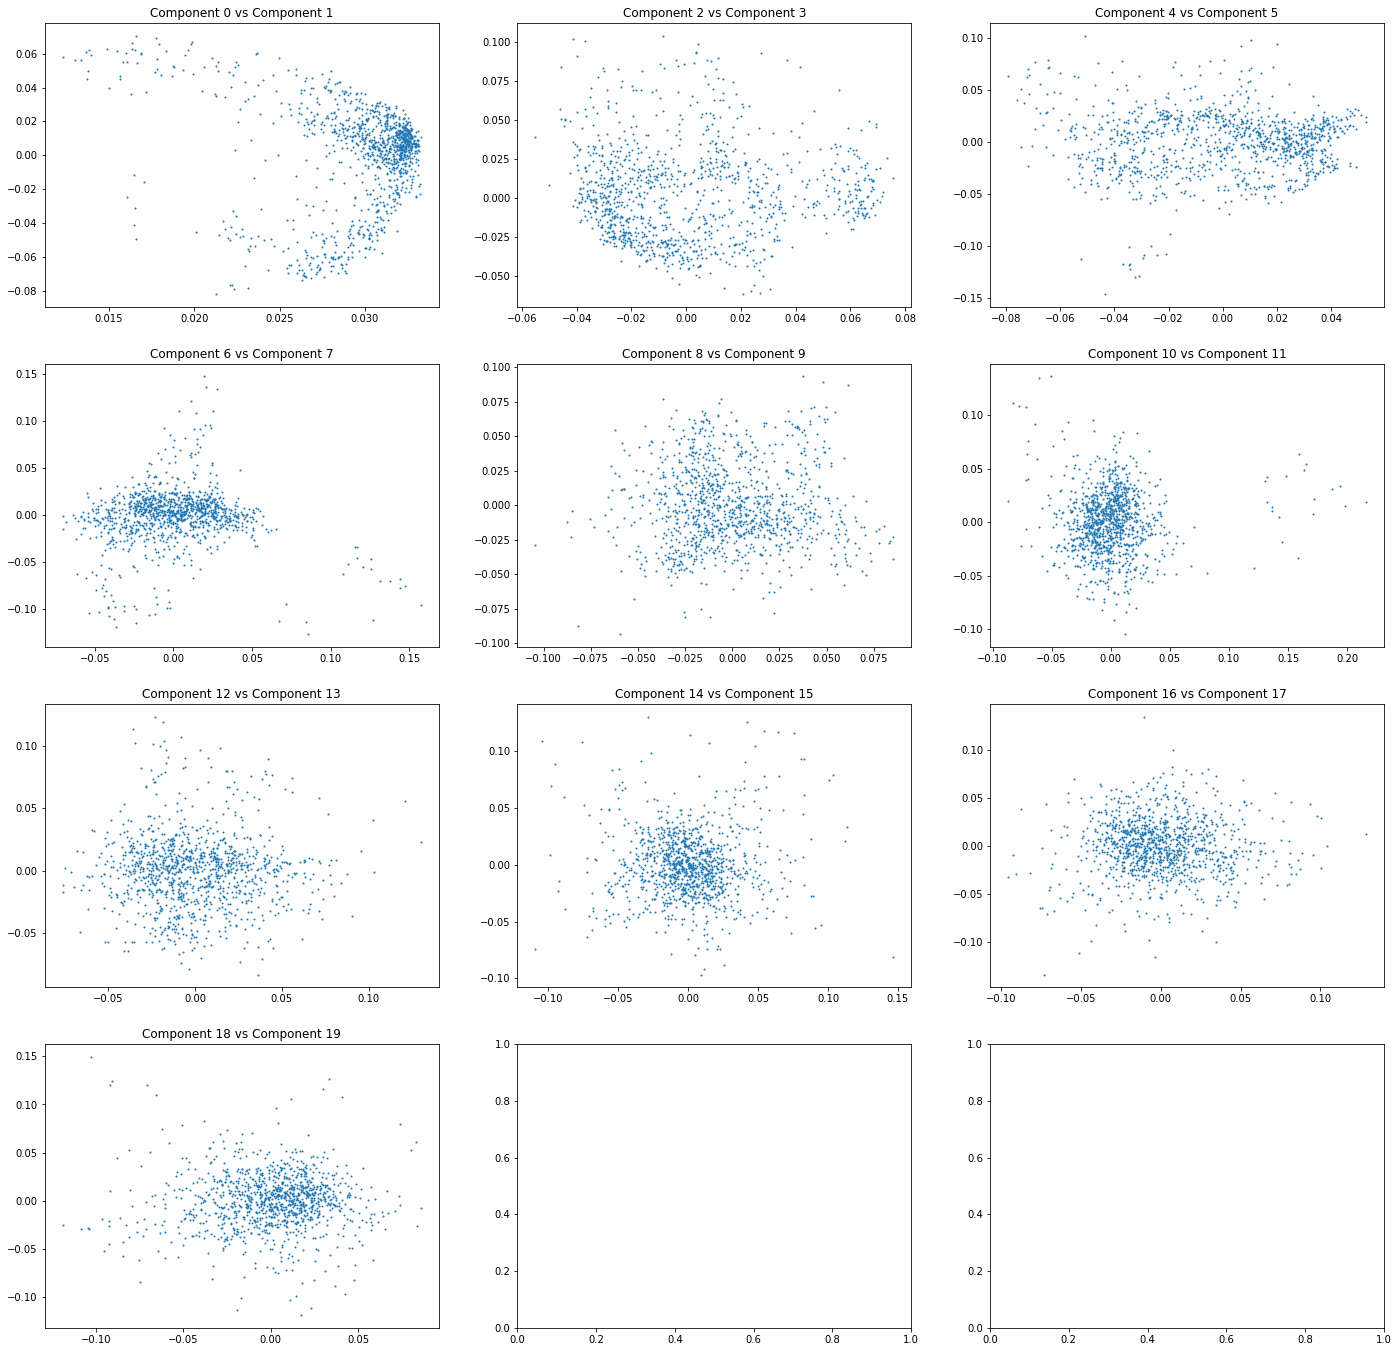

In [20]:
## Let's plot the first few components
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize=(24,24))

y = -1
x = 0
for k in range(10):
    x = k%3
    if x == 0: ## True in first round
        y += 1    

    ax[y,x].scatter(PCs.components_[(2*k),:], PCs.components_[(2*k+1),:], s=1)
    ax[y,x].set_title(f'Component {2*k} vs Component {2*k+1}')

Clearly the first few components are the most informative and from component 8 onwards you see more of a gaussian-like distribution, which indicate they capture mostly noise. Similarly we can plot the cumulative variance explained by each component and you will see that the plot start to reach an plateau around that point. The last few components do explain some variance, but they are less clear so it's better to exclude them.

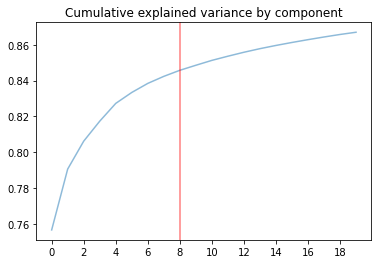

In [21]:
ncomp=8

plt.plot(np.cumsum(PCs.explained_variance_ratio_), alpha=.5)
plt.title(f'Cumulative explained variance by component')
plt.axvline(ncomp, color='red', alpha=.5)
plt.xticks(np.arange(0, 20, 2));

#### Embedding

Next we're going to perform t-Stochastic Neighbour Embedding (tSNE). The mathematics behind tSNE are quite complex and not very intuitive, however the result makes interpreting  
data actually a lot more intuitive! Briefly said, tSNE aims to represent similaries between points that exist in high dimensional space (for instance tens of thousands of genes)  
by projecting these points onto a 2-dimensional (or 3-D) plane. Points that are similar to each other will be placed near each other. However, distance is not a measure for  
dissimilarity here since long distances are warped *i.e.* only local structure is preserved. Take the image below as an example. You can unfold it from 3D to 2D while still preserving  
the structure of cells. So we 'unfold' our data so to speak.

![swiss roll](https://bioinformatics-training.github.io/intro-machine-learning-2017/images/swiss_roll_manifold_sculpting.png)

To get a better sense of what is going on have a look at [this website](https://distill.pub/2016/misread-tsne/).

In [22]:
from sklearn.manifold import TSNE
TSNE = TSNE(init='pca', random_state=1) ## TSNE uses a random seed to initiate, meaning that the results don't always look the same!
TSNE.fit(PCs.components_[:ncomp,:].T)
print(f'We now have a {TSNE.embedding_.shape} dataframe that we can use to plot')

We now have a (1129, 2) dataframe that we can use to plot


Notice that we set a 'random state' (also called a seed), this is a number that the algorithm needs to initialize i.e. where to start from. If you change this the results will also change! It is often a good idea to set a random state to a fixed number to keep results more consistent.

The resulting 2D projection can be plotted to give a sense of the distribution of the cells. What do you think? Can you see any groups in this data that are probably different from each other?

Text(0.5, 1.0, 'tSNE of mouse cortex, hippocampus and ventricular zone cells (E18.5)')

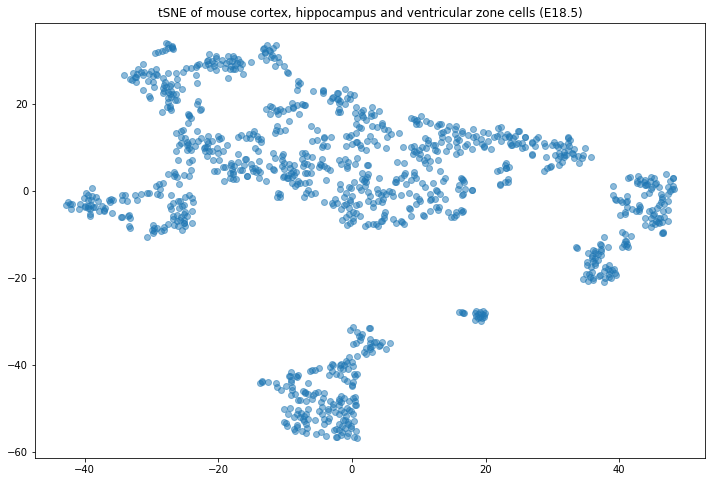

In [23]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(TSNE.embedding_[:,0], TSNE.embedding_[:,1], alpha=.5)
ax.set_title('tSNE of mouse cortex, hippocampus and ventricular zone cells (E18.5)')

## Clustering

Whe now have a visual representation of the structure of our data, but we haven't quite divided our data in different groups of cells yet. This process of statisticially dividing the data into meaningful  
groups is usually referred to as 'clustering' and can be performed in many different ways. Currently graph-based methods are very popular, but depending on your data, how much you already know about  
the cells and what questions you have there are many different methods you can apply. We will demonstrate one simple method that is included in the scikit-learn library and is very easy to apply.

We will cluster our data using Spectral Clustering. This is a form of graph-based clustering where you first build a graph of cells based on the eigenvalues (spectrum) of their similarity matrix and then try  
to cut that graph into groups to identify the different clusters. The assumption is that similar data points form communities that are difficult to separate. A downside here is that we need to define  
a number of clusters that we wish to identify. There are however also community detection alghoritms that don't require a set number of cluster (for instance the Leiden or Louvain methods).

In [24]:
from sklearn.cluster import SpectralClustering

Spectral = SpectralClustering(n_clusters=10, n_neighbors=20, random_state = 1)
Spectral.fit(PCs.components_[:ncomp,:].T)

SpectralClustering(affinity='rbf', assign_labels='kmeans', coef0=1, degree=3,
                   eigen_solver=None, eigen_tol=0.0, gamma=1.0,
                   kernel_params=None, n_clusters=10, n_components=None,
                   n_init=10, n_jobs=None, n_neighbors=20, random_state=1)

We can plot the cluster labels as colors in our tSNE to see if the separation makes sense.

Text(0.5, 1.0, 'Spectral clustering')

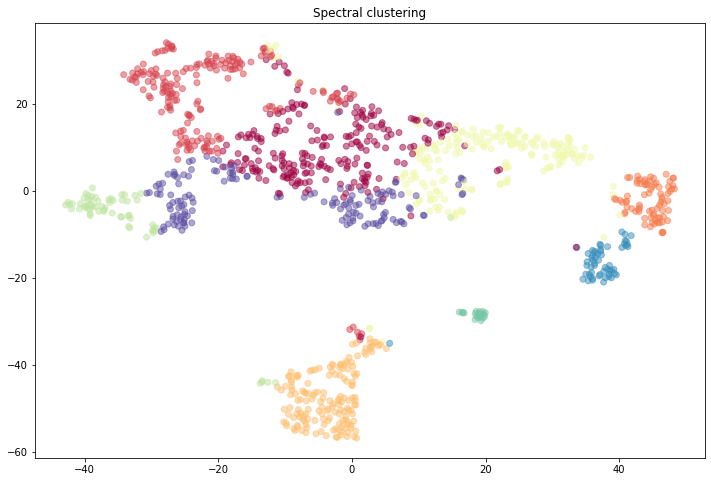

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(TSNE.embedding_[:,0], TSNE.embedding_[:,1], c = Spectral.labels_, cmap= 'Spectral', alpha=.5)
ax.set_title('Spectral clustering')

Try to change some of the clustering parameters and look at the results. They change quite a bit and you can imagine it's important to be aware of what values you use to do your clustering.

Different clustering methods yield different results because they take different parts of the underlying structure of the data into account. In addition there are often multiple parameters to take into account, which also influence the clustering results. It is often wise to try multiple different methods and to compare results.

## Cell type markers

Now we have clusters, but we don't know what any of them actually are. Let's plot the expression of some markers to see what our clusters correspond to.  
*Tnc* is a marker for proliferation, *i.e.* these are dividing cells. *Top2a* is another cell cycle gene (S/G2).  *Eomes* is a marker for Neuroblasts.  
These are cells that are committed to a neuronal fate, but are still maturing and migrating to their final positions. 

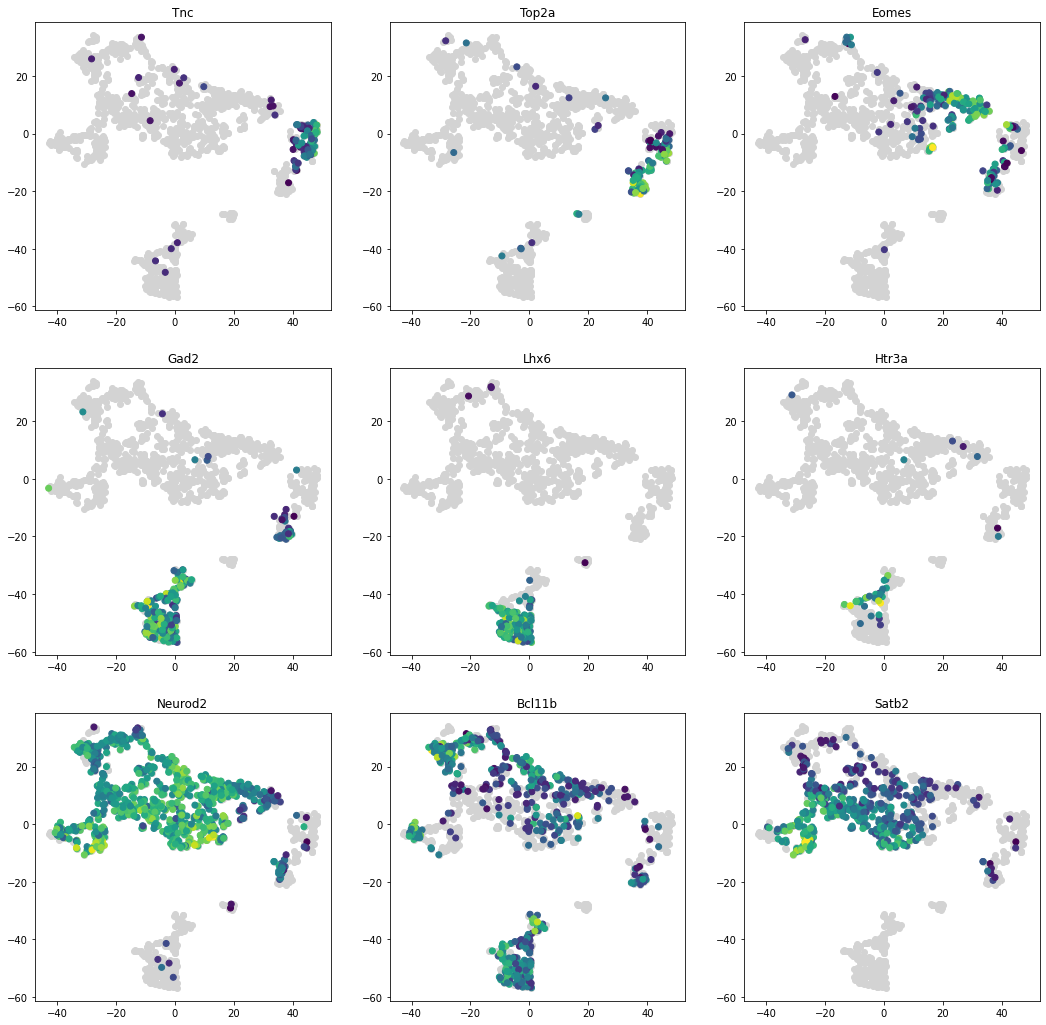

In [26]:
## Let's plot the expression of some markers we would expect to see

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(18,18))
markers = ['Tnc','Top2a', 'Eomes',  
           'Gad2', 'Lhx6', 'Htr3a', 
           'Neurod2', 'Bcl11b', 'Satb2']

y = -1
x = 0
for k in range(len(markers)):
    marker = markers[k]
    x = k%3
    if x == 0:
        y += 1    

    c = norm[genes == marker,:][0]
        
    ax[y,x].scatter(TSNE.embedding_[:,0], TSNE.embedding_[:,1], color = 'lightgray')
    ax[y,x].scatter(TSNE.embedding_[c>0,0], TSNE.embedding_[c>0,1], c = c[c>0], cmap = 'viridis')
    ax[y,x].set_title(f'{marker}')

**Exercise** Explain what these markers indicate. What are the major cell types here? Use [this](http://mousebrain.org/genesearch.html) cell type atlas to figure out what the different populations are. Why do some markers span across clusters and are other confined to one population (*Gad2*/*Lhx6*)?

# Take home assignment

Submit your assignments as a word document or pdf and include problem numbers along with your answers/images/printouts etc. Attach your raw code to your report. You will be graded first on getting the correct answer/producing the plot or image to each problem. In the event that you get the answer wrong, partial credit can be received if you leave comments (using the # sign) in your code to explain what your program is doing at each step. Include at comments on at least 50% of lines of your code to receive this credit. Comments should explain what each line is doing in the program context - not just what it does in isolation. As a test, if the comment were taken alone, would it still tell you something about the rest of the program, or would it merely tell you what can literally be deduced from reading the code itself on that line. Comments should also be concise since the goal is to make the code easier to understand, not burdensome. E.g.:

In [27]:
# for i in my_list: #loop through each item in order to update the sum
#     sum = sum + i #update the sum with item i from my_list
#     If sum > threshold: #check if sum exceeds the threshold
#         threshold_exceeded = True #update status of threshold check

If you get stuck, remember that it is ok to google for ideas or troubleshooting. Many examples exist online that can help you accomplish parts of the problem. Outside of thiscourse, you will often need to quickly accomplish complex programming tasks, and skillfully utilizing online resources is an important habit to develop. Where it is warranted, give credit to the sources you obtain code from by citing them with comments in the code.  

The following excercises are designed to be completed after the 'scRNA-seq' computer excercises. The problems require you to load the cluster labels, gene names and the normalized data. You can either rerun your script and add the solutions to the two problems at the end (just make sure to send in only the assignments and not the whole script) or you can save your results from that script using the line below:

## Problem 1: Gene expression Box-plots

While it can be very useful to show expression levels of genes on a tsne-plot to show cluster relationships and general enrichments, sometimes you want to more explicitly look at level differences. For this reason it can be better to use a boxplot or violin plot. Let's plot the expression of *Gad2*, an important interneuron marker that we also looked at in the excersises, but this time in a boxplot. For this you will need to load the numpy module and the matplotlib module.

It is convention to plot the log normalized data in these kind of plots since you can read them very intuitively. 
After normalizing the data you need to do the following things:

* Create a figure and axis object. Give the figure a width of 12 and height of 8
* Select the row correspondig to the correct gene.
* Split the row into seperate vectors by indexing using the cluster labels.
* Use the box fuction in matplotlib.pyplot to plot the expression (boxes). Show outliers as '+'.
* Set the title and y-axis description.

Replace the '''####''' statements to finish the exercise.
Also finish the code annotations (Text behind the two hashtags (##)) by explaining clearly what the line of code does.

In [28]:
import matplotlib.cm as cm  ## We import the colormap module from matplotlib

## 
g = 'Gad2'

## 
fig = '''####'''
ax = fig.add_subplot(111)

## 
boxes = []
n_labels = len(np.unique(Spectral.labels_))

## 
for x in range('''####'''):
    boxes.append(norm['''####''', Spectral.labels_ == '''####'''])

## 
bplot = ax.boxplot('''####''', labels = range('''####'''), sym='''####''', patch_artist=True)

## 
ax.set_title(f'{'''####'''} expression')
ax.set_ylabel('''####''')

# 
cmap = cm.ScalarMappable(cmap='Spectral')
unique_labels = range(n_labels)
for patch, color in zip(bplot['boxes'], cmap.to_rgba(unique_labels)):
    patch.set_facecolor('''####''')


SyntaxError: ignored

## Problem 2: Mitochondrial Content

The mitochondrial content of a cell is often used as a quality measure. While some particular cell types tend to have slightly higher mitochondrial content, very high levels are usually an indicator of high cellular stress. We usually filter these cells from the data as these cells are often dead and not representative of 'healthy' tissue.

* Plot the summed mitochondrial content (normalized against the total UMI) of each cell in a histogram. 
* Use the unnormalized matrix  and the corresponding gene_names list

**Hint** The names of mitochondrial genes in most annotations start with 'mt-'. You get them with the following function: 
* list(filter(lambda x: 'mt-' in x, gene_names))

Replace the '''####''' statements to finish the exercise.
Also finish the code annotations (Text behind the two hashtags (##)) by explaining clearly what the line of code does.

In [ ]:
## 
mito = '''####'''

## 
k = [x in '''####''' for x in '''####''']

## 
mito_content = np.sum('''####'''.toarray()[k,:], axis='''####''') / '''####'''

## 
plt.figure(figsize=(12,6))
plt.hist('''####''', alpha=.5, bins=30)
plt.title('Mitochondrial content')